In [1]:
#%pip install pandera
import numpy as np
import pandas as pd
import pandera as pa
from typing import Type, Optional
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta
import datetime

# Data Cleaning
## DateTime Parsing & Resolution

The first thing that needs to happen so that we can perform a time series analysis is the conversion of dates and settlement periods into actual datetime objects. I will use the Pandas builtin `.to_datetime` for most of the parsing, but there are multiple date formats in the data, so I will have to treat each individually. I then write some functions to aid in converting settlement periods to DateTimes

In [2]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND"]]

In [3]:
# Since multiple date formats appear in this csv, checking that parsing function works for both.
raw_date1 = "05-JUN-2022"
raw_date2 = "2023-06-05"

parsed_date1 = pd.to_datetime(raw_date1)
parsed_date2 = pd.to_datetime(raw_date2)

print(parsed_date1, parsed_date2)
print(type(parsed_date1), type(parsed_date2))

2022-06-05 00:00:00 2023-06-05 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
# List comprehensions are slightly faster than hidden for-loops in apply, and make sure that to_datetime doesn"t fall back to dateutil.parser.parse
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [5]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [6]:
sett2date(df.SETTLEMENT_DATE[0], df.SETTLEMENT_PERIOD[0])

Timestamp('2009-01-01 00:15:00')

In [7]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [8]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [9]:
df["DAY_NAME"] = df["DATETIME"].dt.day_name()
df["MONTH"] = df["DATETIME"].dt.month
df["YEAR"] = df["DATETIME"].dt.year
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")

## Exploratory Data Analysis: Trends

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResultsWrapper
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.tsa.stattools import adfuller

First I get a feel for the data by checking one (representative) week near the beginning of the data and average out the monthly fluctuation in all the years.

In [11]:
one_week = df.iloc[336:672]

In [12]:
one_week.iloc[200]

SETTLEMENT_DATE      2009-01-12 00:00:00
SETTLEMENT_PERIOD                      9
ND                                 31041
DATETIME             2009-01-12 04:15:00
DAY_NAME                          Monday
MONTH                                  1
YEAR                                2009
YEAR_MONTH           2009-01-01 00:00:00
Name: 536, dtype: object

C:\Users\dstan\AppData\Local\Temp\ipykernel_8896\100940403.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  week_plot.set_xticklabels(week_plot.get_xticklabels(), rotation=45)


[Text(14252.0, 0, '2009-01-08'),
 Text(14253.0, 0, '2009-01-09'),
 Text(14254.0, 0, '2009-01-10'),
 Text(14255.0, 0, '2009-01-11'),
 Text(14256.0, 0, '2009-01-12'),
 Text(14257.0, 0, '2009-01-13'),
 Text(14258.0, 0, '2009-01-14'),
 Text(14259.0, 0, '2009-01-15')]

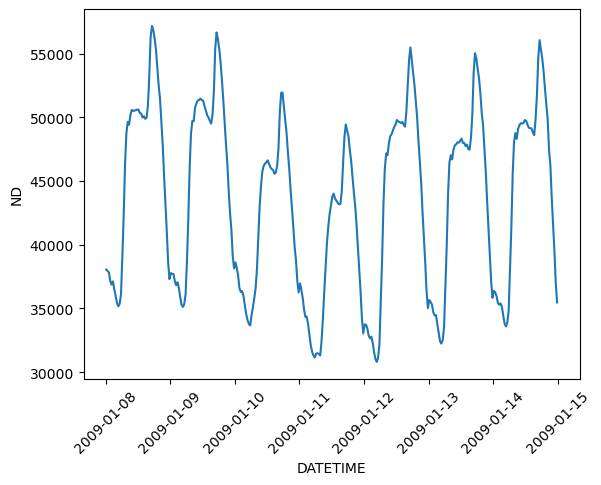

In [13]:
one_week_demand = one_week[["DATETIME","ND"]]
week_plot = sns.lineplot(data=one_week_demand, x="DATETIME", y="ND")
week_plot.set_xticklabels(week_plot.get_xticklabels(), rotation=45)

In [14]:
month_lvl_df = df.groupby("MONTH")["ND"].agg("mean").reset_index()

In [15]:
month_lvl_df.head()

,MONTH,ND
0,1,36803.464508
1,2,35882.142330
2,3,33704.937584
3,4,30042.515885
4,5,28337.429896


C:\Users\dstan\AppData\Local\Temp\ipykernel_8896\604420649.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  year_plot.set_xticklabels(year_plot.get_xticklabels())


[Text(0.0, 0, '0'),
 Text(2.0, 0, '2'),
 Text(4.0, 0, '4'),
 Text(6.0, 0, '6'),
 Text(8.0, 0, '8'),
 Text(10.0, 0, '10'),
 Text(12.0, 0, '12'),
 Text(14.0, 0, '14')]

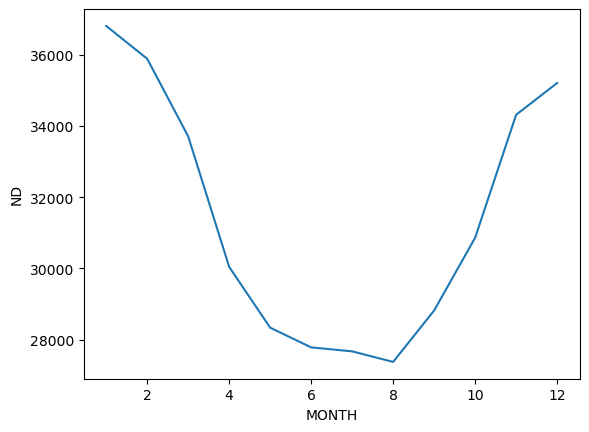

In [16]:
year_plot = sns.lineplot(x=month_lvl_df["MONTH"],y=month_lvl_df["ND"], data=month_lvl_df)
year_plot.set_xticklabels(year_plot.get_xticklabels())

In [17]:
post_2009 = df.where(df["YEAR_MONTH"] > pd.to_datetime("2009-01-01"))
ym_lvl_df = post_2009.groupby("YEAR_MONTH")["ND"].agg("mean").reset_index()

C:\Users\dstan\AppData\Local\Temp\ipykernel_8896\3455183066.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ym_plot.set_xticklabels(ym_plot.get_xticklabels(), rotation=45)


[Text(13879.0, 0, '2008'),
 Text(14610.0, 0, '2010'),
 Text(15340.0, 0, '2012'),
 Text(16071.0, 0, '2014'),
 Text(16801.0, 0, '2016'),
 Text(17532.0, 0, '2018'),
 Text(18262.0, 0, '2020'),
 Text(18993.0, 0, '2022'),
 Text(19723.0, 0, '2024'),
 Text(20454.0, 0, '2026')]

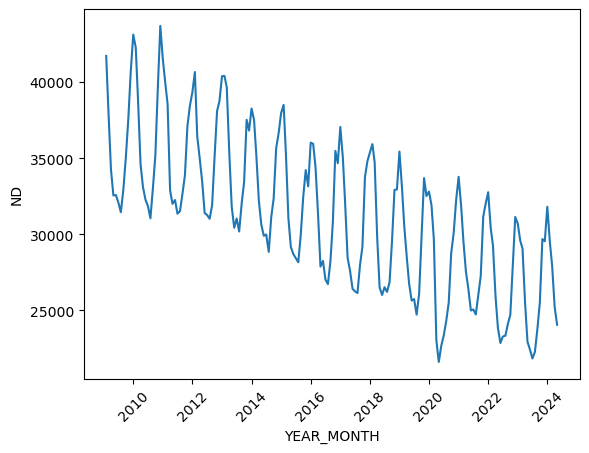

In [18]:
ym_plot = sns.lineplot(x=ym_lvl_df["YEAR_MONTH"],y=ym_lvl_df["ND"], data=ym_lvl_df)
ym_plot.set_xticklabels(ym_plot.get_xticklabels(), rotation=45)

## Regression: SARIMA (TS only)

In [19]:
# sm complained that ND was not numeric

df["ND"] = pd.to_numeric(df["ND"], errors="coerce")

full_data = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

train_data = full_data[(full_data.index >= pd.to_datetime("2011-01-01")) & (full_data.index < pd.to_datetime("2022-01-01"))]

test_data = full_data[full_data.index >= pd.to_datetime("2022-01-01")]

In [20]:
def s_decomp_plot(data: Series, period: int) -> None:
    """
    Plots the seasonal decomposition of a timeseries based on the given period
    """
    decomp = sm.tsa.seasonal_decompose(data, period=period)

    trend = decomp.trend
    seasonal = decomp.seasonal
    resid = decomp.resid

    plt.figure(figsize=(15, 8))

    plt.subplot(411)
    sns.lineplot(data=data, color="blue")
    plt.title("Original Series")

    plt.subplot(412)
    sns.lineplot(data=trend, label="Trend", color="orange")
    plt.title("Trend Component")

    plt.subplot(413)
    sns.lineplot(data=seasonal, label="Seasonal", color="green")
    plt.title("Seasonal Component")

    plt.subplot(414)
    sns.lineplot(data=resid, label="Residual", color="red")
    plt.title("Residual Component")

    plt.tight_layout()
    plt.show()

In [21]:
def selection_stationarity_diff(data: Series, lag_val: int) -> None:
    """
    Plots the ACF and PACF for the timeseries, as well as the differenced timeseries. Checks for stationarity of both explicitly (ADF)
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(data, lags=lag_val, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data, lags=lag_val, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(data.diff(), lags=lag_val, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data.diff(), lags=lag_val, ax=ax[1])
    plt.show()

    adf_test = adfuller(data)
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")

    adf_test_diff = adfuller(data.diff().dropna())
    print(f"ADF Statistic (post diff): {adf_test_diff[0]}")
    print(f"p-value (post diff): {adf_test_diff[1]}")

In [22]:
def rmse_mape(fitted: Type[SARIMAXResultsWrapper], test_set: Series) -> None:
    predictions = fitted.get_forecast(steps=len(test_set))
    predicted_mean = predictions.predicted_mean

    rmse = RMSE(test_set, predicted_mean)
    mape = MAPE(test_set, predicted_mean)
    
    print(f"Root Mean Squared Error: {rmse}\nMean Average Percentage Error: {mape*100:.3f}%")

In [23]:
def grid_search_sarima(data: Series, exog: Optional = None, p_list: list = [0,1,2], d_list: list = [1], q_list: list = [1,2], s_period: list = [12]) -> None:
    """
    Performs a grid search based on AIC to select best parameters for SARIMA(X) model
    """
    p = P = p_list
    q = Q = q_list
    d = D = d_list
    s = s_period

    pdq = list(itertools.product(p, d, q))
    s_pdq = list(itertools.product(P, D, Q, s))

    best_aic = float("inf")
    best_pdq = None
    best_s_pdq = None

    candidate_model_sarima = None
    candidate_fit_sarima = None

    for order in pdq:
        for s_order in s_pdq:
            try:
                candidate_model_sarima = SARIMAX(data, exog=exog, order=order, seasonal_order=s_order)
                candidate_fit_sarima = candidate_model_sarima.fit(disp=False, maxiter=1000, method='powell')
                
                if candidate_fit_sarima.aic < best_aic:
                    best_aic = candidate_fit_sarima.aic
                    best_pdq = order
                    best_s_pdq = s_order
            
            except:
                continue

    print(f"Best pdq: {best_pdq}\nBest PDQ: {best_s_pdq}\nAIC: {best_aic}")

In [24]:
def plot_fcast_sarima(fitted: Type[SARIMAXResultsWrapper], train_set: Series, test_set: Series) -> None:
    """
    Plots the training and test data, with forecast and confidence overlaid
    """
    fcast = fitted.get_forecast(steps=len(test_set))
    
    fcast_values = fcast.predicted_mean
    conf_int = fcast.conf_int()

    actualized_df = pd.concat([train_set, test_set])


    plt.figure(figsize=(15, 5))
    plt.plot(train_set, label="Training Data", color="C0")
    plt.plot(test_set, label="Test Data",color="C0")
    plt.plot(fcast_values, label="Forecast", color="orange")

    plt.fill_between(fcast_values.index, 
        conf_int.iloc[:, 0], 
        conf_int.iloc[:, 1], color="orange", alpha=0.1)

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Values")
    
    plt.show()

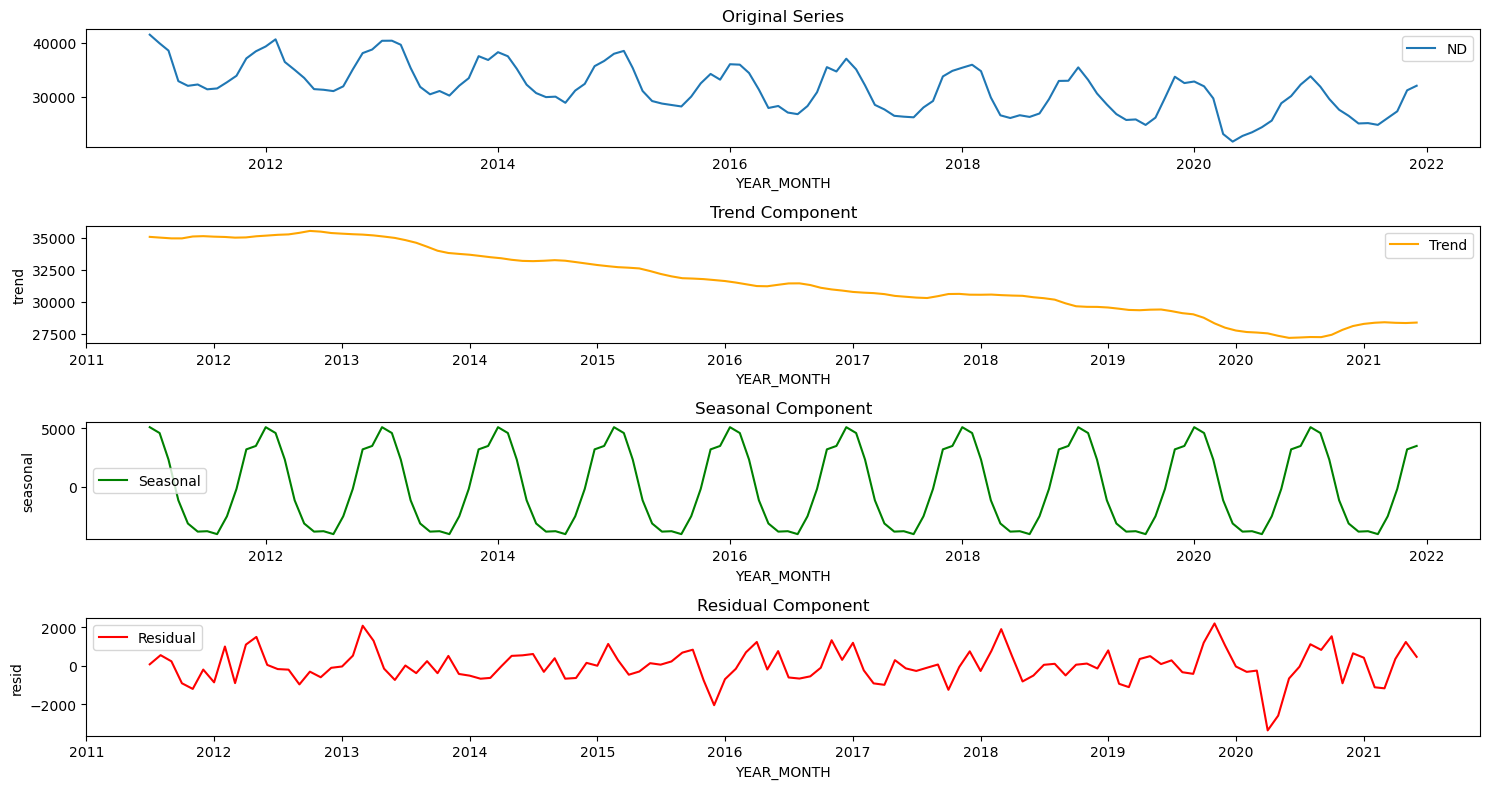

In [25]:
s_decomp_plot(train_data, 12)

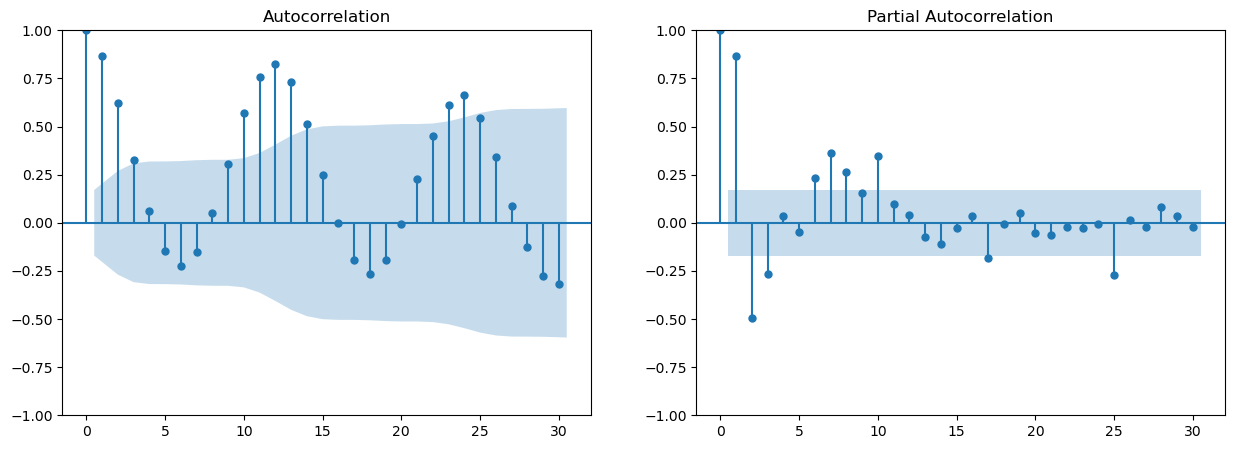

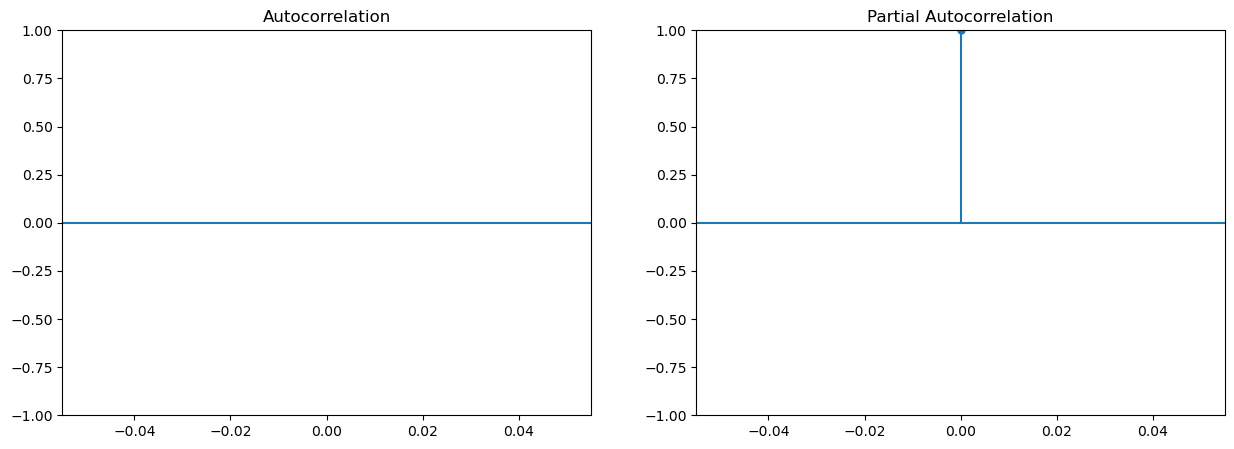

ADF Statistic: -0.6222989782285494
p-value: 0.8658633473639566
ADF Statistic (post diff): -8.570489233800474
p-value (post diff): 8.22309605943017e-14


In [26]:
selection_stationarity_diff(train_data, 30)

In [27]:
model_sarima = SARIMAX(train_data, order=(1,1,2), seasonal_order=(1,1,2,12))
fit_sarima = model_sarima.fit(disp=False, maxiter=1000, method="powell")
print(fit_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ND   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1028.512
Date:                            Tue, 18 Jun 2024   AIC                           2071.025
Time:                                    16:20:05   BIC                           2090.478
Sample:                                01-01-2011   HQIC                          2078.924
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2721      0.804      0.338      0.735      -1.303       1.847
ma.L1         -0.4302      0.791   

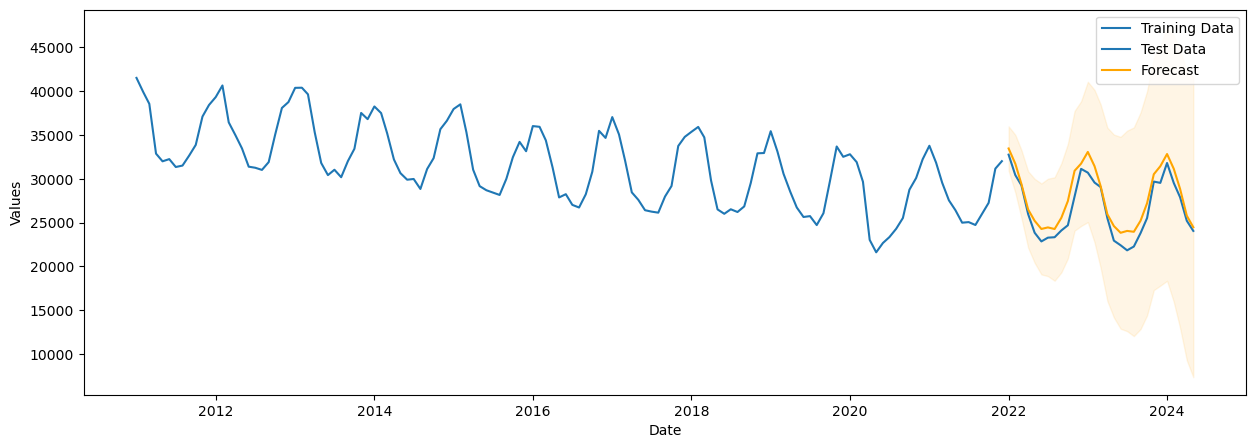

In [28]:
plot_fcast_sarima(fit_sarima, train_data, test_data)

In [29]:
rmse_mape(fit_sarima, test_data)

Root Mean Squared Error: 1478.630291017401
Mean Average Percentage Error: 4.998%


In [30]:
grid_search_sarima(train_data)

c:\Users\dstan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\dstan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\dstan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\dstan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\dstan\anaconda3\Lib\site-pa

Best pdq: (0, 1, 1)
Best PDQ: (0, 1, 1, 12)
AIC: 2064.8264976183823


In [31]:
final_model_sarima = SARIMAX(train_data, order=(0,1,1), seasonal_order=(0,1,1,12))
final_fit_sarima = final_model_sarima.fit(disp=False, maxiter=1000, method="powell")
print(final_fit_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ND   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1029.413
Date:                            Tue, 18 Jun 2024   AIC                           2064.826
Time:                                    16:20:30   BIC                           2073.164
Sample:                                01-01-2011   HQIC                          2068.212
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1602      0.071     -2.263      0.024      -0.299      -0.021
ma.S.L12      -0.3201      0.022   

c:\Users\dstan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


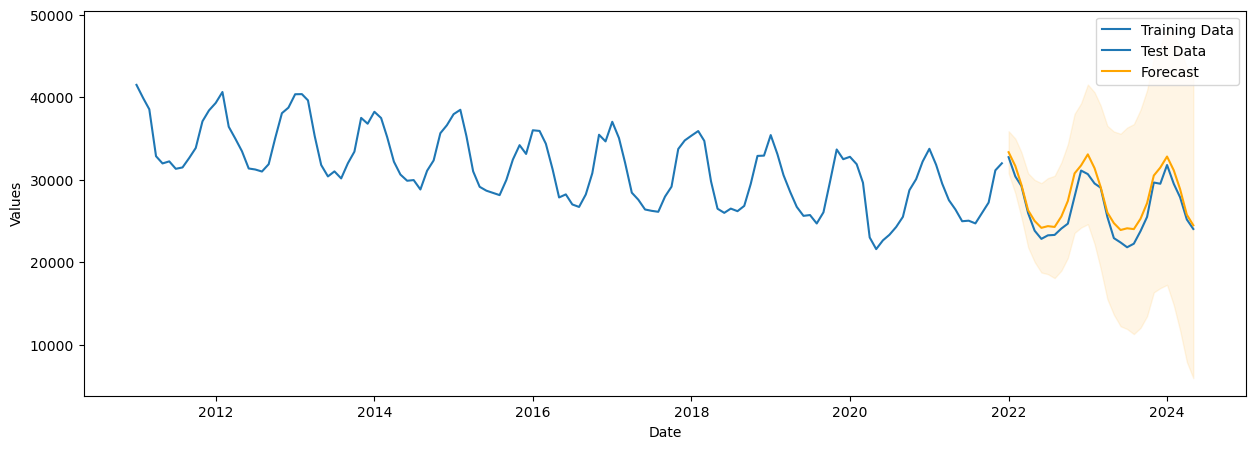

In [32]:
plot_fcast_sarima(final_fit_sarima, train_data, test_data)

In [33]:
rmse_mape(final_fit_sarima, test_data)

Root Mean Squared Error: 1482.5004407150611
Mean Average Percentage Error: 5.007%


## Collection of Weather Data

In [34]:
import meteostat as met

In [35]:
ldn = met.Point(51.5072, -0.1276)
edi = met.Point(55.9533, -3.1883)
cdf = met.Point(51.4837, -3.1681)

In [36]:
df["DATETIME"][df.index[-1]]

Timestamp('2024-05-09 23:45:00')

In [37]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 5, 1)

In [38]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end)

In [40]:
ldn_wdat = ldn_wdat.fetch()

In [41]:
ldn_wdat.head()

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2011-01-01,4.8,1.9,6.9,77.0,14.1,1018.7,2160.0
2011-02-01,7.3,4.7,9.8,43.0,15.9,1014.4,2160.0
2011-03-01,8.1,4.0,12.2,15.0,NaN,1022.5,7560.0
2011-04-01,13.2,7.8,18.8,2.0,13.3,1019.5,13080.0
2011-05-01,14.4,9.3,19.3,25.0,NaN,1018.0,13080.0


In [42]:
ldn_wdat = ldn_wdat[["tavg", "wspd", "tsun"]]

In [44]:
# deg C, km/h, min

ldn_wdat.interpolate(inplace=True)
ldn_wdat.head()

,tavg,wspd,tsun
time,,,
2011-01-01,4.8,14.1,2160.0
2011-02-01,7.3,15.9,2160.0
2011-03-01,8.1,14.6,7560.0
2011-04-01,13.2,13.3,13080.0
2011-05-01,14.4,13.6,13080.0


In [45]:
ldn_wdat.isna().sum()

tavg    0
wspd    0
tsun    0
dtype: int64